In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_22.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_53.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_69.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_51.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_88.JPG
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_4.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_75.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_58.png
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_12.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_16.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_72.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_62.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_2.jpg
/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_45.jpg
/kaggle/

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD,RMSprop, Adadelta, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import keras
from keras import Sequential
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [6]:
class_names=sorted(os.listdir('/kaggle/input/vehicle-type-recognition/Dataset'))
print(class_names)
print(len(class_names))

['Bus', 'Car', 'Truck', 'motorcycle']
4


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


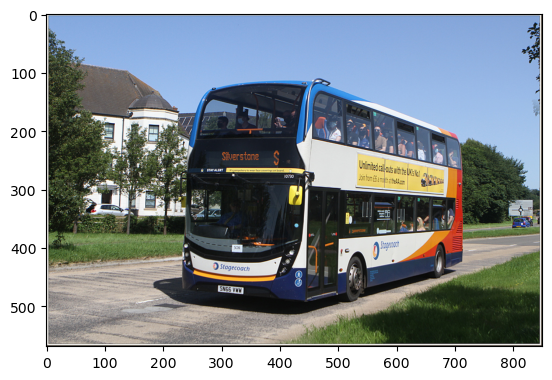

In [23]:
#plot the image of the images 
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/kaggle/input/vehicle-type-recognition/Dataset/Bus/Image_12.jpg')
implot = plt.imshow(img)
plt.show()

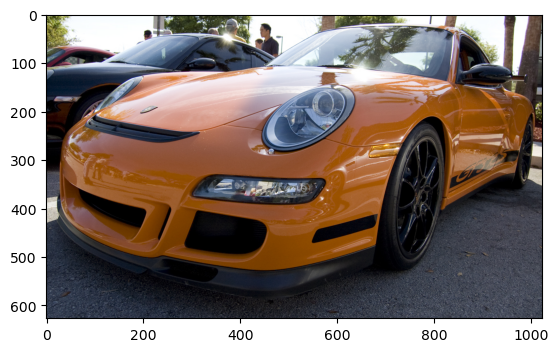

In [18]:
img = mpimg.imread('/kaggle/input/vehicle-type-recognition/Dataset/Car/Image_12.jpg')
implot = plt.imshow(img)
plt.show()

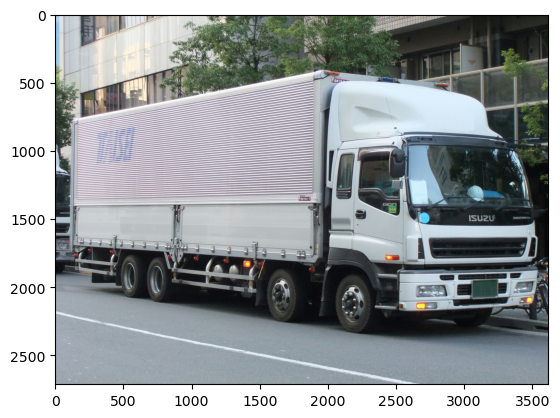

In [19]:
img = mpimg.imread('/kaggle/input/vehicle-type-recognition/Dataset/Truck/Image_10.jpg')
implot = plt.imshow(img)
plt.show()

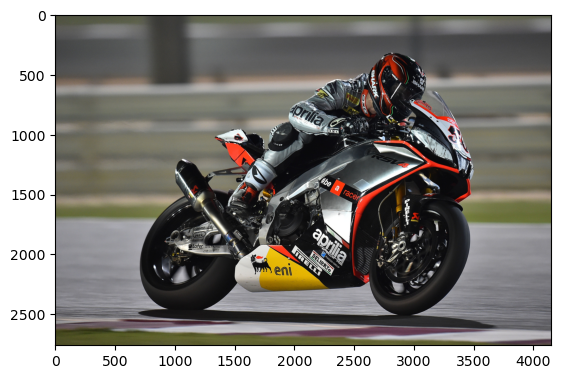

In [30]:
img = mpimg.imread('/kaggle/input/vehicle-type-recognition/Dataset/motorcycle/Image_1.jpeg')
implot = plt.imshow(img)
plt.show()

In [7]:
img_width = 224
img_height = 224
channels = 3
batch_size = 32
seed_train_validation = 1 

In [8]:
data_ds = keras.utils.image_dataset_from_directory(
    directory ='/kaggle/input/vehicle-type-recognition/Dataset',
    image_size = (224, 224),
    seed = seed_train_validation,
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    shuffle = True)

Found 400 files belonging to 4 classes.


In [9]:
data_list = list(data_ds.as_numpy_iterator())

images = np.concatenate([data[0] for data in data_list])
labels = np.concatenate([data[1] for data in data_list])

train_images,testval_images,train_labels,testval_labels = train_test_split(
    images, labels, test_size=0.2, random_state=seed_train_validation)

test_images,val_images,test_labels,val_labels = train_test_split(
    testval_images, testval_labels, test_size=0.5, random_state=seed_train_validation)

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(8).shuffle(True)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(8)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(8)

print('len',len(train_ds),len(val_ds),len(test_ds))

len 40 5 5


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
!pip install keras-tuner

In [12]:
import keras_tuner
from keras_tuner import RandomSearch
from keras.models import Sequential, Model

In [14]:
def built_finetune_model(hp): 
    base_model = ResNet50(
    weights ='imagenet',
    include_top = False,
    input_shape = (224,224,3),
) 
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output                
    x = (Dropout(0.2))(x)  
    x = Flatten()(x)

    predictions = Dense(len(class_names) , activation = 'softmax')(x) #len(class_names)
    finetune_model = Model(inputs = base_model.input , outputs =  predictions)
    adam = Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4]))
    sgd = SGD(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4]))
    rmsprop = RMSprop(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4]))
    nadam = Nadam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4]))
    adadelta = Adadelta(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4]))
    optimizer1 = hp.Choice('optimizer', values = ['adam','sgd','rmsprop','nadam','adadelta'])
    finetune_model.compile(optimizer =optimizer1,
                           loss = 'categorical_crossentropy',
                           metrics = ['accuracy'])

    return finetune_model

In [16]:
tunner2.get_best_hyperparameters()[0].values
model3 = tunner2.get_best_models(num_models =1)[0]
model3.fit(train_ds , 
    epochs = 30 , 
    validation_data=val_ds,
    steps_per_epoch = len(train_ds) ,
    validation_steps=len(val_ds),)

Epoch 1/30
40/40 [==============================] - 33s 741ms/step - loss: 2.0299 - accuracy: 0.9156 - val_loss: 2.0753 - val_accuracy: 0.8750
Epoch 2/30
40/40 [==============================] - 28s 699ms/step - loss: 0.6484 - accuracy: 0.9656 - val_loss: 0.6943 - val_accuracy: 0.9500
Epoch 3/30
40/40 [==============================] - 28s 701ms/step - loss: 7.9662e-06 - accuracy: 1.0000 - val_loss: 0.6608 - val_accuracy: 0.9500
Epoch 4/30
40/40 [==============================] - 28s 690ms/step - loss: 2.3097e-08 - accuracy: 1.0000 - val_loss: 0.6602 - val_accuracy: 0.9500
Epoch 5/30
40/40 [==============================] - 28s 710ms/step - loss: 1.0431e-08 - accuracy: 1.0000 - val_loss: 0.6602 - val_accuracy: 0.9500
Epoch 6/30
40/40 [==============================] - 30s 750ms/step - loss: 0.0420 - accuracy: 0.9937 - val_loss: 1.5428 - val_accuracy: 0.9000
Epoch 7/30
40/40 [==============================] - 30s 759ms/step - loss: 0.3637 - accuracy: 0.9844 - val_loss: 6.9964 - val_accu

In [31]:
from sklearn.metrics import classification_report
from keras.utils import to_categorical

test_predictions = model3.predict(test_ds)
test_predicted_labels = np.argmax(test_predictions, axis=1)
#print(val_predicted_labels.shape)
print(list(test_predicted_labels)[0:10])

test_true_labels = []
for _, labels in test_ds:
    test_true_labels.extend(labels.numpy())  # Convert the labels tensor to a numpy array and add it to the list

test_true_labels = np.array(test_true_labels)  # Convert to NumPy array if not already
#print(val_true_labels.shape)
#print(val_true_labels)

def one_hot_to_category(one_hot_encoded, categories):
    index = np.argmax(one_hot_encoded, axis=1)
    return [categories[i] for i in index]

test_true_labels2 = one_hot_to_category(test_true_labels,list(range(len(class_names))))
print(test_true_labels2[0:10])


report = classification_report(test_true_labels2, test_predicted_labels, target_names=class_names, digits=4)
print(report)

5/5 [==============================] - 4s 599ms/step
[1, 2, 1, 0, 3, 1, 1, 0, 2, 3]
[1, 2, 1, 0, 3, 1, 1, 0, 0, 3]
              precision    recall  f1-score   support

         Bus     1.0000    0.7143    0.8333        14
         Car     0.9091    1.0000    0.9524        10
       Truck     0.7000    1.0000    0.8235         7
  motorcycle     1.0000    1.0000    1.0000         9

    accuracy                         0.9000        40
   macro avg     0.9023    0.9286    0.9023        40
weighted avg     0.9248    0.9000    0.8989        40

